In [ ]:
#Used to mount google drive to colab so that files can be accessed from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing necessary libraries for this part of the project
from keras.utils import image_dataset_from_directory
import tensorflow as tf
# Directories
#specifying the directories where the datasets of train, validation and test are stored
train_dirs = [
    '/content/drive/MyDrive/ProjetoIA/dataset/train1',
    '/content/drive/MyDrive/ProjetoIA/dataset/train2',
    '/content/drive/MyDrive/ProjetoIA/dataset/train4',
    '/content/drive/MyDrive/ProjetoIA/dataset/train5'
]
validation_dir = '/content/drive/MyDrive/ProjetoIA/dataset/train3'
test_dir = '/content/drive/MyDrive/ProjetoIA/dataset/test'

# Parameters
IMG_SIZE = 150
BATCH_SIZE = 32

# Function to load datasets from multiple directories and concatenate them
def load_and_concatenate_datasets(directories, img_size, batch_size):
    datasets = []
    for directory in directories:
        dataset = image_dataset_from_directory(
            directory,
            image_size=(img_size, img_size),
            batch_size=batch_size
        )
        datasets.append(dataset)
    return datasets

# Load train datasets and concatenate
train_datasets = load_and_concatenate_datasets(train_dirs, IMG_SIZE, BATCH_SIZE)
train_dataset = tf.data.Dataset.sample_from_datasets(train_datasets)

# Load validation and test datasets
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Extract class names from one of the datasets
example_dataset = image_dataset_from_directory(
    train_dirs[0],
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
class_names = example_dataset.class_names
print(class_names)

Found 10400 files belonging to 10 classes.
Found 9600 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 1 classes.
Found 10400 files belonging to 10 classes.
['000_airplane', '001_automobile', '002_bird', '003_cat', '004_deer', '005_dog', '006_frog', '007_horse', '008_ship', '009_truck']


In [ ]:
#Let us first load the VGG16 model
from tensorflow.keras.applications.vgg16 import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))



58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
from tensorflow import keras
import numpy as np
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)# tem q se juntar a lista pra caber na rede

#This is the function that we useto compute the output of the
#feature extraction section for each of the datasets

In [ ]:
# extract features and labels for each dataset
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 23ms/step


In [ ]:
#Now, we build a dense network
#that will play the role of the
#classification section
#Because models behave just like layers, we can use them as any other
#layers to build a new model.

from tensorflow import keras
from keras import layers
inputs = keras.Input(shape=(4, 4, 512))#cada imagem gera um cubo, formato de entrada do vgg16
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)#desliga 20% por entrada
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
# Adding ModelCheckpoint callback
# and EarlyStopping callback of 5 epochs to avoid overfitting
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/ProjetoIA/models/modeloT_TL_FE_without_DA_best.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1)

In [ ]:
# Compile and train the model

model.compile(
 loss='sparse_categorical_crossentropy',
 optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
 metrics=['accuracy'])
history = model.fit(
  train_features, train_labels,
  epochs=25,
  validation_data=(val_features, val_labels),
  callbacks=[checkpoint_cb, early_stop])


Epoch 1/25
1249/1250 [============================>.] - ETA: 0s - loss: 4.9272 - accuracy: 0.6214
Epoch 1: val_loss improved from inf to 2.26409, saving model to /content/drive/MyDrive/ProjetoIA/models/modeloT_TL_FE_without_DA_best.h5
1250/1250 [==============================] - 6s 4ms/step - loss: 4.9259 - accuracy: 0.6215 - val_loss: 2.2641 - val_accuracy: 0.7815
Epoch 2/25
1238/1250 [============================>.] - ETA: 0s - loss: 2.3438 - accuracy: 0.7845
Epoch 2: val_loss improved from 2.26409 to 1.87422, saving model to /content/drive/MyDrive/ProjetoIA/models/modeloT_TL_FE_without_DA_best.h5
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3415 - accuracy: 0.7849 - val_loss: 1.8742 - val_accuracy: 0.8154
Epoch 3/25
1234/1250 [============================>.] - ETA: 0s - loss: 1.8065 - accuracy: 0.8217
Epoch 3: val_loss improved from 1.87422 to 1.66329, saving model to /content/drive/MyDrive/ProjetoIA/models/modeloT_TL_FE_without_DA_best.h5
1250/1250 [==========

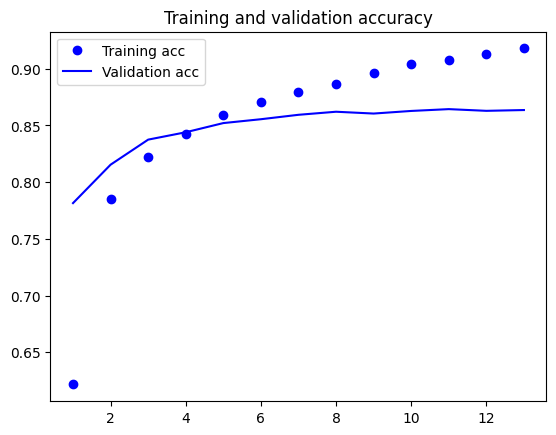

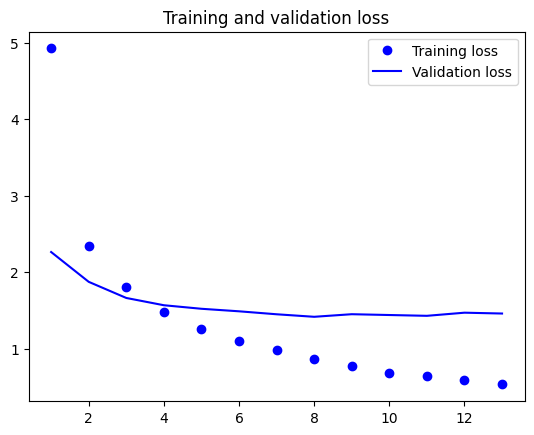

In [ ]:
#Displaying curves of loss and accuracy

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:

from keras import models
inputs = keras.Input(shape=(150, 150, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
outputs = model(x)
full_model = keras.Model(inputs, outputs)

In [ ]:
full_model.compile(
 loss='sparse_categorical_crossentropy',
 optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
 metrics=['accuracy'])

In [ ]:
#• Now, we save the model
full_model.save('/content/drive/MyDrive/ProjetoIA/models/CNN_TL_FE_without_data_augmentation.h5')

In [ ]:
#We can later load it and test it:
from tensorflow import keras
loaded_model = keras.models.load_model('/content/drive/MyDrive/ProjetoIA/models/modeloT_TL_FE_without_DA_best.h5')
# case been loaded change bellow full_model->loaded_model

In [ ]:
# case been loaded change bellow full_model->loaded_model
val_loss, val_acc = full_model.evaluate(validation_dataset)
print('val_acc:', val_acc)

313/313 [==============================] - 14s 44ms/step - loss: 1.4598 - accuracy: 0.8636
val_acc: 0.8636000156402588


Foram avaliados 313 batches no conjunto de validação
Perda calculada no conjunto de validação 1.4598
Previsão do conjunto de validação com 86.36% das previsões foram corretas.